In [19]:
from copy import deepcopy
from random import choices
from ase.visualize import view
from importlib import reload
import numpy as np
from ase import Atoms
from itertools import cycle, islice

import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt

import graphical
reload(graphical)
import abtem_backend as backend
reload(backend)
import ase_funcs
reload(ase_funcs)
from SingleOrigin import SingleOrigin as so
reload(so)

# Random seeds from random.org (x60)
seeds = [87353, 39801, 56916, 62903, 76446, 40231, 92312, 43299, 72148, 37976,
         93458, 22838, 78787, 89538, 53240, 82349, 85799, 94281, 53053, 10655,
         94124, 6828, 21401, 75500, 7576, 74045, 70885, 23437, 25341, 59347,
         60517, 66924, 78696, 48347, 580, 51813, 42469, 29790, 59860, 53418,
         89435, 44210, 62350, 82493, 92909, 64157, 4272, 86548, 78072, 33308,
         44844, 59068, 71774, 9102, 15659, 15109, 51366, 28656, 53572, 81414]

In [ ]:
# Preview the cif file to make sure it looks right
# This pops up a new interactive window where you can rotate / pan / zoom / etc. with the cif model
cif_cell = graphical.gui_open(ffmt="cif")
view(cif_cell)
# Technically, reading the cif returns a generator (because cifs can store multiple crystal structures in one file),
# in which case this only shows the first valid structure.  But practically, just avoid using cif files with multiple structures in them

First we want to check some thin samples; with these, we can exhaustively enumerate the possible configurational variations within a column, which should give us a little bit of insight into how quickly we're losing information about the in-column chemistry.  Let's build models up to 4 projected cells thick.

In [2]:
thin_models = backend.build_from_cif(graphical.gui_get_path(),
                                     zas=(1, 1, 0),
                                     tks=[2, 6, 8, 12],
                                     tilings=(2, 2))

In [ ]:
# Preview a model to make sure it looks right (this previews the thickest model)
view(thin_models[-1].atoms)

In [3]:
chopped_models = [ase_funcs.split_by_projected_columns(model.atoms, kinds="Al") for model in thin_models]

In [4]:
# Treat the one cell thick case specially, since we just want to pick at random
for col in chopped_models[0]:
    sym = choices(["Al", "Sc"], weights=[0.6, 0.4], k=1)[0]
    col[0].symbol = sym

In [5]:
# Then, for the rest, let's exhaustively go through all possible variations and assign them to a column
# For the four cell thick case, this is 1:1; for thinner models, we will need to repeat some
for model, cm in zip(thin_models[1:], chopped_models[1:]):
    n_vars = pow(2, len(cm[0]))
    # Get variations, and unwrap the returned tuples to remove the labels (which we don't need right now)
    new_cols = [col[1] for col in ase_funcs.gen_variations(Atoms(cm[0]), subs=("Al", "Sc"))]

    if len(cm) >= n_vars:
        new_cols = list(islice(cycle(new_cols), len(cm)))  # Repeat to account for all columns
    elif len(cm) <= n_vars:
        raise ValueError("Too many possible variations; increase supercell x-y size")
    # else len(cm) == n_vars, and we don't need to change new_cols

    # ndarray for fast & easy 2D lookup
    # Index guide: [column, pos_in_col, tuple], where for tuple 0 is index in model and 1 is symbol
    cm_array = np.array([[(atom.index, atom.symbol) for atom in col] for col in cm])
    for i, col in enumerate(new_cols):
        for j, atom in enumerate(col):
            cm_array[i, j, 1] = atom.symbol
    del new_cols  # We don't need this anymore
    #  Finally, we can modify the models to have the correct elements!
    for atom in model.atoms:
        if atom.symbol in ["Al"]:
            cm_location = np.where(cm_array[:, :, 0] == str(atom.index))
            atom.symbol = cm_array[cm_location[0], cm_location[1], 1][0]


Now we'll simulate some HAADF images based on these models

In [6]:
db = backend.DetectorBuilder()
potential_parameters = backend.PotentialParameters(sampling=0.1,
                                                   slice_thickness=1,
                                                   device="gpu",
                                                   storage="cpu",
                                                   fp_cfgs=100,
                                                   fp_sigmas={"Al": 0,
                                                              "Sc": 0,
                                                              "N":  0})
probe_parameters = backend.ProbeParameters(device="gpu")

In [7]:
# Fast!  Only takes about 2 minutes
thin_results = []
for model in thin_models:
    thin_results.append(backend.sim_stem([model],
                                    db,
                                    potential_prms=potential_parameters,
                                    probe_prms=probe_parameters,
                                    kinds=["haadf"]))

In [8]:
imgs = []
for result in thin_results:
    res = result[0]  # Unwrap single element list
    meas = res.measurement[0]
    img = meas.interpolate(tuple([x/4 for x in res.grid.sampling]), kind="fft").tile((3, 3)).array
    img = so.image_norm(img)
    imgs.append(img)

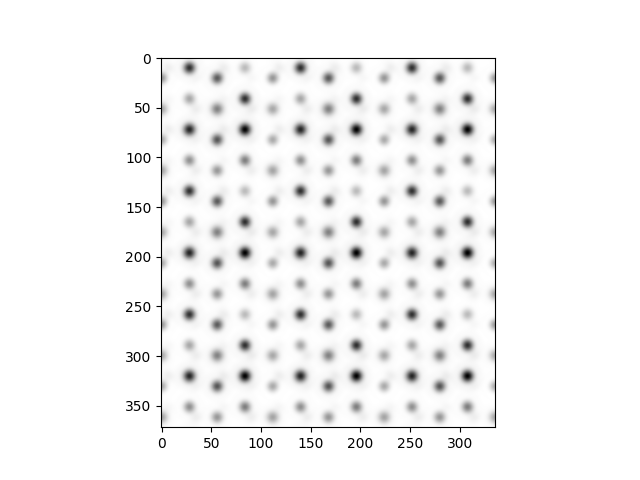

In [9]:
# Preview one of the images, to make sure
plt.imshow(imgs[3], cmap="binary")
plt.show()

Now that we have our images, we need to analyze them with SingleOrigin.

In [10]:
cif_path = r"C:\Users\charles\Documents\AlScN\raw\AlN.cif"
uc = so.UnitCell(cif_path)

za = [1, 1, 0]  # Zone axis direction
a2 = [0, 0, -1]  # Apparent horizontal axis in projection
a3 = [1, -1, 0]  # Most vertical axis in projection

uc.project_zone_axis(za, a2, a3, ignore_elements=["N"])
uc.combine_prox_cols()

transformed lattice parameters: 
 a1:     3.111 
 a2:     4.978 
 a3:     5.3884 
 alpha:  90.0 
 beta:   90.0 
 gamma:  90.0 

Distances (in Angstroms) being combined...
None to combine


,u,v,elem,site_frac,x,y,weight
0,0.0,0.66666,Al,1.0,0.000,1.796119,1
1,0.5,0.33333,Al,1.0,2.489,0.898059,1


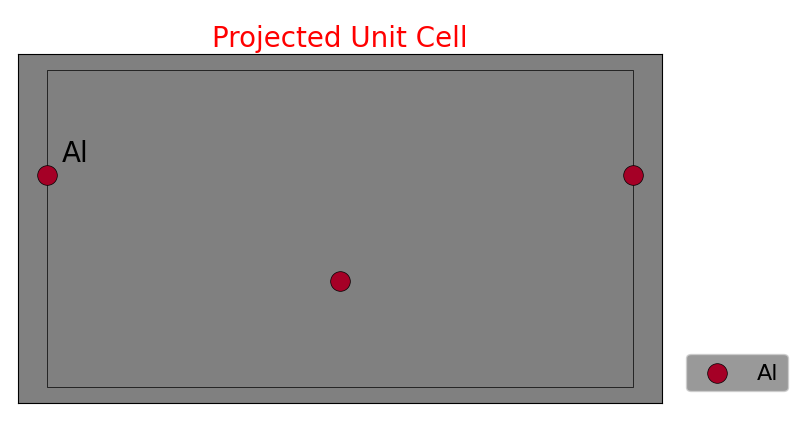

In [11]:
uc.plot_unit_cell()

In [12]:
hrimgs = [so.HRImage(img) for img in imgs]
lattices = [hrimg.add_lattice("AlN", uc) for hrimg in hrimgs]
matplotlib.use("QtAgg")
for lattice in lattices:
    lattice.fft_get_basis_vect(a1_order=2, a2_order=1, sigma=2)
%matplotlib widget

[[180. 168.]
 [168. 157.]]
done selecting 

[[180. 168.]
 [168. 157.]]
done selecting 

[[180. 168.]
 [168. 157.]]
done selecting 

[[180. 168.]
 [168. 157.]]
done selecting 



In [13]:
matplotlib.use("QtAgg")
for lattice in lattices:
    lattice.roi_mask = np.ones(imgs[0].shape)
    lattice.define_reference_lattice()
%matplotlib widget

pick coordinates: [197.  195.9] 

detected peak coordinates: [196, 196] 

Creating reference lattice...
Performing rough reference lattice refinement...
Refinement iteration 1
0 min 0.00 sec
Refinement iteration 2
0 min 0.00 sec
Refinement iteration 3
0 min 0.00 sec
pick coordinates: [196.02 195.78] 

detected peak coordinates: [196, 196] 

Creating reference lattice...
Performing rough reference lattice refinement...
Refinement iteration 1
0 min 0.01 sec
Refinement iteration 2
0 min 0.00 sec
Refinement iteration 3
0 min 0.00 sec
pick coordinates: [196.44 195.94] 

detected peak coordinates: [196, 196] 

Creating reference lattice...
Performing rough reference lattice refinement...
Refinement iteration 1
0 min 0.01 sec
Refinement iteration 2
0 min 0.01 sec
Refinement iteration 3
0 min 0.01 sec
pick coordinates: [196.44 195.94] 

detected peak coordinates: [196, 196] 

Creating reference lattice...
Performing rough reference lattice refinement...
Refinement iteration 1
0 min 0.01 sec
Re

In [14]:
for lattice in lattices:
    lattice.fit_atom_columns(buffer=0, local_thresh_factor=0, use_background_param=True,
                             use_bounds=True, use_circ_gauss=False, parallelize=True,
                             peak_grouping_filter=None)

    # Must have only one column per projected unit cell.  If no sublattice meets this criterion,
    #  specify a specific column in the projected cell.
    lattice.refine_reference_lattice(filter_by='elem', sites_to_use='all')

Creating atom column masks...
Step 1(Preparation...): 0 min 0.02 sec
Step 2(fitting masks): 0 min 0.16 sec
Step 3(grouping masks): 0 min 0.16 sec
Step 4(match masks to lattice points): 0 min 0.00 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.00 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 137/137 [00:11<00:00, 12.38it/s]


Done. Fitting time: 0 min 11.1 sec
Origin shift: [0.228131   0.42386003]
Optimized basis vectors: [[ 5.60021236e+01  4.39857438e-03]
 [-3.55241202e-04 -3.09925734e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 2.2037 %
Shear component: -0.000090 (radians)
Estimated Pixel Size: 8.791 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.01 sec
Step 2(fitting masks): 0 min 0.16 sec
Step 3(grouping masks): 0 min 0.17 sec
Step 4(match masks to lattice points): 0 min 0.00 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.00 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 140/140 [00:00<00:00, 823.53it/s]


Done. Fitting time: 0 min 0.4 sec
Origin shift: [0.38487105 0.25580523]
Optimized basis vectors: [[ 5.60392988e+01 -2.68959712e-03]
 [ 3.31748885e-03 -3.09587616e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 2.0319 %
Shear component: 0.000155 (radians)
Estimated Pixel Size: 8.793 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.01 sec
Step 2(fitting masks): 0 min 0.16 sec
Step 3(grouping masks): 0 min 0.16 sec
Step 4(match masks to lattice points): 0 min 0.00 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.00 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 140/140 [00:00<00:00, 790.96it/s]


Done. Fitting time: 0 min 0.3 sec
Origin shift: [0.09193464 0.3851543 ]
Optimized basis vectors: [[ 5.60002660e+01  1.27577174e-02]
 [-4.36895689e-03 -3.10034857e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 2.2413 %
Shear component: -0.000369 (radians)
Estimated Pixel Size: 8.790 (pm)
Creating atom column masks...
Step 1(Preparation...): 0 min 0.01 sec
Step 2(fitting masks): 0 min 0.15 sec
Step 3(grouping masks): 0 min 0.16 sec
Step 4(match masks to lattice points): 0 min 0.00 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.0 sec
Step 7(Finish prep...): 0 min 0.00 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 140/140 [00:00<00:00, 1052.63it/s]


Done. Fitting time: 0 min 0.4 sec
Origin shift: [0.07250956 0.33501732]
Optimized basis vectors: [[ 5.59849713e+01 -1.00629066e-03]
 [-1.60227140e-03 -3.10010194e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 2.2602 %
Shear component: -0.000034 (radians)
Estimated Pixel Size: 8.791 (pm)


(<Figure size 1300x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Warning: scalebar length is based on the pixel size estimated from the reference lattice. The user should specify the calibrated pixel size if known.'}>)

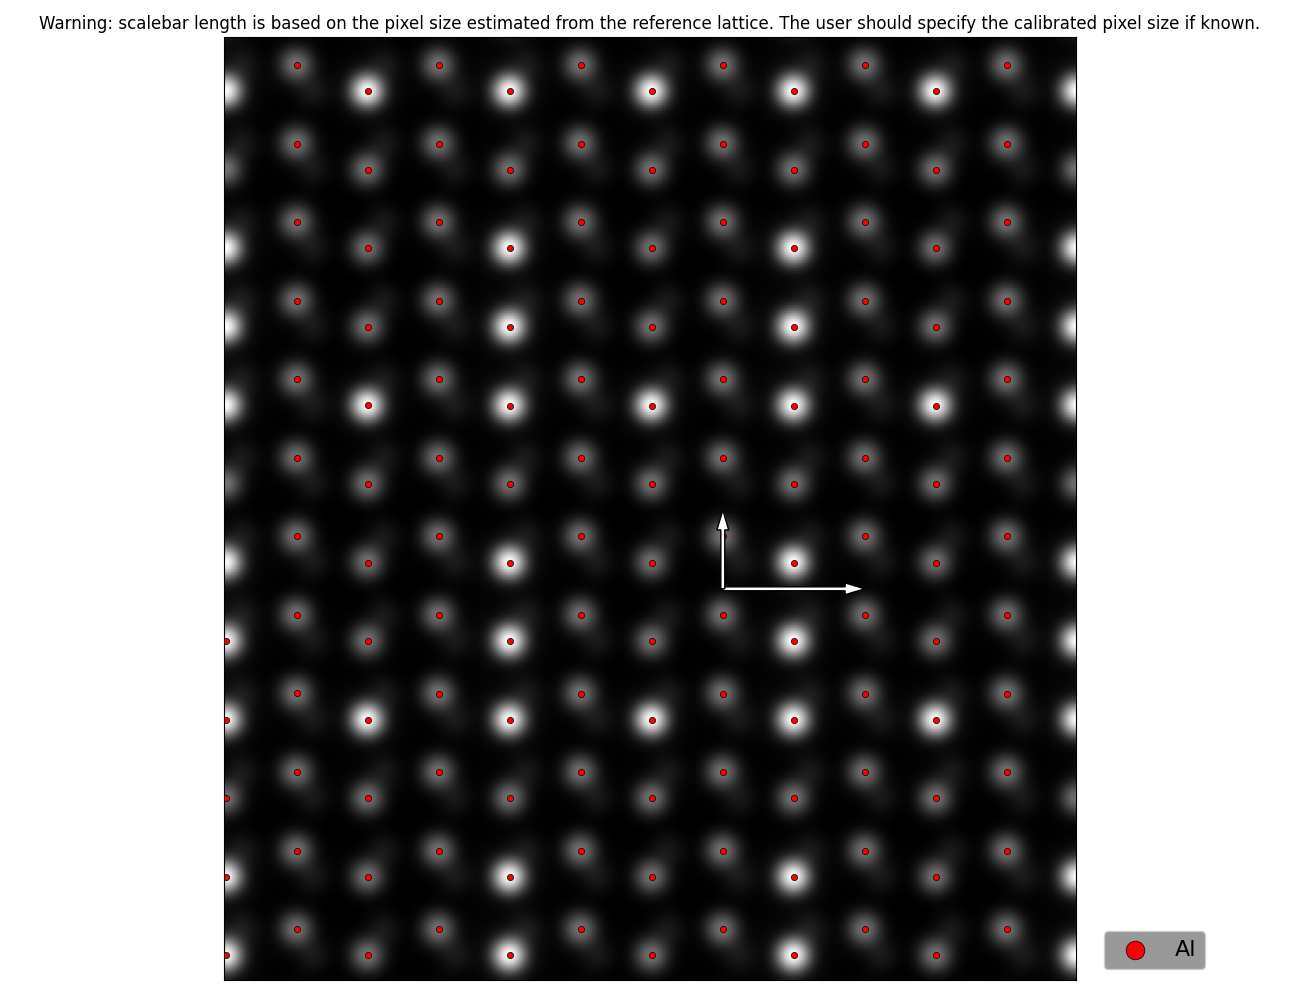

In [17]:
# Check one of the fits to make sure everything worked
hrimgs[0].plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None,
                                     outlier_disp_cutoff=100, fit_or_ref="ref")

In [21]:
frames = []
for lat in lattices:
    frame = deepcopy(lat.at_cols)
    frame.drop(["site_frac", "x", "y", "weight"], axis=1, inplace=True)  # We don't need these cols
    frame.reset_index(drop=True, inplace=True)
    frames.append(frame)